<a href="https://colab.research.google.com/github/yurigalindo/PyTorchSamples/blob/main/Colab%20Notebooks/True_Iconip_Splits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%%capture
!unzip /content/gdrive/My\ Drive/Meteoros -d IC
!unzip /content/gdrive/My\ Drive/iconip_csvs -d IC

In [ ]:
!ls

gdrive	helper_modules.py  IC  __pycache__  sample_data


In [ ]:
#General imports
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
!cp /content/gdrive/My\ Drive/helper_modules.py .
from helper_modules import *

In [ ]:
#Utilities for loading the images and creating datasets

import os
import os.path
from torch.utils.data import Dataset
from torchvision import get_image_backend

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def default_loader(path):
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
      return pil_loader(path)

class ImageFromCSV(Dataset):
    """Class for creating an image dataset based on a csv with filenames and
    a directory containing the images
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        image = default_loader(img_name)
        label = self.csv.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image , label

In [ ]:
#Creation of datasets

#Transforms to convert the input into the input expected by resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

image_datasets = dict()


#Creates datasets and stores them in a dictionary
for split in ['places','shuffle']:
  image_datasets[split] = dict()
  for fold in range(4):
    image_datasets[split][fold] = {x:ImageFromCSV("IC/iconip_csvs/{0}_{1}{2}.csv".format(x,split,fold+1),"IC/Meteoros",transform=data_transforms[x])
                    for x in ['train', 'valid','test']}

In [ ]:
print(image_datasets)

{'places': {0: {'train': <__main__.ImageFromCSV object at 0x7f38146a3c18>, 'valid': <__main__.ImageFromCSV object at 0x7f38751a0160>, 'test': <__main__.ImageFromCSV object at 0x7f3887a1ab38>}, 1: {'train': <__main__.ImageFromCSV object at 0x7f38146a3c50>, 'valid': <__main__.ImageFromCSV object at 0x7f387978f898>, 'test': <__main__.ImageFromCSV object at 0x7f3888593160>}, 2: {'train': <__main__.ImageFromCSV object at 0x7f38145d3080>, 'valid': <__main__.ImageFromCSV object at 0x7f38145d3160>, 'test': <__main__.ImageFromCSV object at 0x7f38145d3278>}}, 'shuffle': {0: {'train': <__main__.ImageFromCSV object at 0x7f38145d3390>, 'valid': <__main__.ImageFromCSV object at 0x7f38145d34a8>, 'test': <__main__.ImageFromCSV object at 0x7f38145d35c0>}, 1: {'train': <__main__.ImageFromCSV object at 0x7f38145d36d8>, 'valid': <__main__.ImageFromCSV object at 0x7f38145d37f0>, 'test': <__main__.ImageFromCSV object at 0x7f38145d3908>}, 2: {'train': <__main__.ImageFromCSV object at 0x7f38145d3a20>, 'valid'

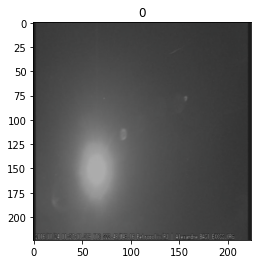

In [ ]:
#Displaying one image from the dataset for debugging purposes

dataloader=torch.utils.data.DataLoader(image_datasets['shuffle'][3]['train'])
plt.ion() 
'''
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

'''
# Get a batch of training data
inputs, classes = next(iter(dataloader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes.item()) #Class 0 corresponds to meteor and 1 to non-meteor

In [ ]:
import matplotlib.pyplot as plt
import torch

class Learner:
    """Class for wrapping a model with training and prediction functionality.
    Stores an optimizer, a training criterion, and datasets. These can be altered
    throught set functions.
    """
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_acc=0
        self.last_acc=0

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            size=inputs.size(0)
            del inputs
            loss = self.criterion(outputs, labels)
            loss.backward()
            
        with torch.no_grad():
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item() 
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("  Avg Loss={}\n  Accuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a
    def change_to_best_model(self):
        self.model.load_state_dict(self.best_model_wts)
    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32,verbose=True):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        batch_cap=self.min_value(training_batchsize,batch_cap)
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=batch_cap,shuffle=True)
        
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            if verbose:
              print("Epoch {} of {}".format(epoch,num_epochs-1))
            
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                try:
                  for micro_batch in range(micro_batches):

                    inputs,labels=next(iterator)
                    new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                    loss+=new_loss
                    corrects+=new_corrects
                    del inputs
                    del labels
                    del new_loss
                    del new_corrects
                    torch.cuda.empty_cache()
                except StopIteration:
                    pass
                self.optimizer.step()
                torch.cuda.empty_cache()

            self.scheduler.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            train_losses.append(loss/len(self.training_dataset))
            if verbose:
              print("Training:")
              self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss/len(self.validation_dataset))
            acc=corrects/len(self.validation_dataset)
            if verbose:
              print("Validation:")
              self.print_statistics(loss/len(self.validation_dataset),acc)
              print()
            self.last_acc=acc
            if(acc>self.best_acc):
              self.best_acc=acc
              self.best_model_wts = copy.deepcopy(self.model.state_dict())
            

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Predicts on a dataset and returns a tensor containing the probabilities of each class 
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        self.model.eval()
        self.optimizer.zero_grad()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [ ]:
def freeze_resnet(model,n):
  """Function that freezes the first n layers of a resnet
  """
  #This is considered as the first layer
  model.conv1.requires_grad=False
  model.bn1.weight.requires_grad=False
  model.bn1.bias.requires_grad=False
  l=1
  flag=False #Flag for stopping the iteration
  for layer in [model.layer1,model.layer2,model.layer3,model.layer4]:
    #Resnets group the layers on these 4 layer blocks
    if(flag):
      break
    for block in layer:
      if(flag):
        break
      for module in block.children():
        if(l<n):
          #Code for making the conv and batch norm layers untrainable
          if isinstance(module,nn.Conv2d):
            module.requires_grad=False
          elif isinstance(module,nn.BatchNorm2d):
            module.weight.requires_grad=False
            module.bias.requires_grad=False
            l+=1 #Counts each conv + batch group as one layer
        else:
          flag=True
          break
  

In [ ]:
def accuracy_confidence(predictions,labels,threshold=0.5):
  """Given a confidence threshold, takes into account only the predictions above the threshold
  and evaluates accuracy, precision, recall and coverage
  """
  threshold = min(threshold,1-threshold)
  clip_preds = predictions.copy()
  clip_preds[clip_preds>=0.5]=1
  clip_preds[clip_preds<0.5]=0
  mask = np.logical_or(predictions<=threshold,predictions>=1-threshold) #mask for predictions above the threshold
  predicted = mask.sum()
  right_answers = clip_preds == labels
  right_answers[np.logical_not(mask)] = False #answers that were not predicted are not counted as correct
  correct = right_answers.sum()
  if predicted == 0:
    acc =0
  else:
    acc = correct/predicted

  predicted_meteors = clip_preds == 0
  predicted_meteors[np.logical_not(mask)] = False #removing meteors not predicted on
  true_positives = right_answers[predicted_meteors].sum()
  if true_positives == 0:
    precision = recall = 0
  else:
    precision = true_positives/predicted_meteors.sum()
    true_meteors = labels == 0
    true_meteors[np.logical_not(mask)] = False #disconsider the true meteors not predicted on
    recall = true_positives/true_meteors.sum()

  coverage = predicted/len(labels)
  return {'acc':acc ,'cov': coverage , 'prec':precision , 'rec':recall}
  


Total time:2303.9483420848846
fold 3:
{'acc': 0.9773182121414277, 'cov': 1.0, 'prec': 0.9738903394255874, 'rec': 0.9815789473684211}

Total time:2283.9448671340942
fold 3:
{'acc': 0.9786524349566378, 'cov': 1.0, 'prec': 0.9690721649484536, 'rec': 0.9894736842105263}

Total time:2293.2460362911224
fold 3:
{'acc': 0.9653102068045364, 'cov': 1.0, 'prec': 0.943609022556391, 'rec': 0.9907894736842106}

Total time:2294.685469388962
fold 3:
{'acc': 0.9853235490326885, 'cov': 1.0, 'prec': 0.9855263157894737, 'rec': 0.9855263157894737}

Total time:2291.74733042717
fold 3:
{'acc': 0.9786524349566378, 'cov': 1.0, 'prec': 0.9764397905759162, 'rec': 0.9815789473684211}

[0.9773182121414277, 0.9786524349566378, 0.9653102068045364, 0.9853235490326885, 0.9786524349566378]
[0.9738903394255874, 0.9690721649484536, 0.943609022556391, 0.9855263157894737, 0.9764397905759162]
[0.9815789473684211, 0.9894736842105263, 0.9907894736842106, 0.9855263157894737, 0.9815789473684211]


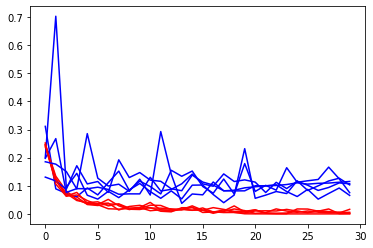

In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracies = list()
precisions = list()
recalls = list()
split = 'shuffle'
for fold in range(3,4): #4 different divisions
  for _ in range(5): #5 different initializations
    #Initializes model with the hyperparameters
    model_ft = models.resnet50(pretrained=True)
    freeze_resnet(model_ft,33)
    num_ftrs=model_ft.fc.in_features
    model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 2),
                              ) #A new fully connected layer with output for 2 classes
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
    learner.set_optimizer(optimizer,scheduler)


    #trains on the training dataset for 30 epochs and changes to the best model on
    #the validation set (early stopping)
    learner.set_datasets(image_datasets[split][fold]['train'],image_datasets[split][fold]['valid'])
    learner.train(30,64,128,batch_cap=64,verbose=False)
    learner.change_to_best_model()

    #evaluates performance on the test set
    preds = learner.predict(image_datasets[split][fold]['test'],128,2)
    preds[torch.isnan(preds)]=1 #some images may have excessive glitches that result in nan output 
                                #these images can be discarded as non meteors
    preds = preds[:,1].numpy() #Predicted probability of being non meteor
    labels = np.array([image_datasets[split][fold]['test'][i][1] for i in range(len(image_datasets[split][fold]['test']))])

    print('fold {0}:'.format(fold))
    info = accuracy_confidence(preds,labels)
    accuracies.append(info['acc'])
    precisions.append(info['prec'])
    recalls.append(info['rec'])
    print(info)
    print()
 
print(accuracies)
print(precisions)
print(recalls)

Total time:2396.175642490387
fold 3:
{'acc': 0.8559015206372194, 'cov': 1.0, 'prec': 0.8122743682310469, 'rec': 0.9401114206128134}

Total time:2377.516095638275
fold 3:
{'acc': 0.7632150615496017, 'cov': 1.0, 'prec': 0.6996935648621042, 'rec': 0.9540389972144847}

Total time:2383.0045821666718
fold 3:
{'acc': 0.8117306299782766, 'cov': 1.0, 'prec': 0.7544444444444445, 'rec': 0.9456824512534819}

Total time:2369.2027390003204
fold 3:
{'acc': 0.776249094858798, 'cov': 1.0, 'prec': 0.7132429614181439, 'rec': 0.9526462395543176}

Total time:2392.3491401672363
fold 3:
{'acc': 0.7994207096307024, 'cov': 1.0, 'prec': 0.7452725250278087, 'rec': 0.9331476323119777}

[0.8559015206372194, 0.7632150615496017, 0.8117306299782766, 0.776249094858798, 0.7994207096307024]
[0.8122743682310469, 0.6996935648621042, 0.7544444444444445, 0.7132429614181439, 0.7452725250278087]
[0.9401114206128134, 0.9540389972144847, 0.9456824512534819, 0.9526462395543176, 0.9331476323119777]


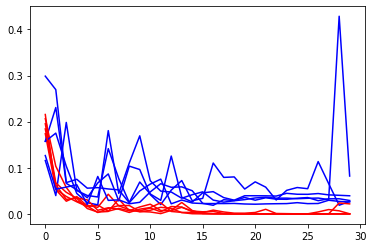

In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


accuracies = list()
precisions = list()
recalls = list()

split = 'places'
for fold in range(3,4): #4 different divisions
  for _ in range(5): #5 different initializations
    #Initializes model with the hyperparameters
    model_ft = models.resnet50(pretrained=True)
    freeze_resnet(model_ft,33)
    num_ftrs=model_ft.fc.in_features
    model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 2),
                              ) #A new fully connected layer with output for 2 classes
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
    learner.set_optimizer(optimizer,scheduler)


    #trains on the training dataset for 30 epochs and changes to the best model on
    #the validation set (early stopping)
    learner.set_datasets(image_datasets[split][fold]['train'],image_datasets[split][fold]['valid'])
    learner.train(30,64,128,batch_cap=64,verbose=False)
    learner.change_to_best_model()

    #evaluates performance on the test set
    preds = learner.predict(image_datasets[split][fold]['test'],128,2)
    preds[torch.isnan(preds)]=1 #some images may have excessive glitches that result in nan output 
                                #these images can be discarded as non meteors
    preds = preds[:,1].numpy() #Predicted probability of being non meteor
    labels = np.array([image_datasets[split][fold]['test'][i][1] for i in range(len(image_datasets[split][fold]['test']))])

    print('fold {0}:'.format(fold))
    info = accuracy_confidence(preds,labels)
    accuracies.append(info['acc'])
    precisions.append(info['prec'])
    recalls.append(info['rec'])
    print(info)
    print()
 
print(accuracies)
print(precisions)
print(recalls)
 

In [ ]:
#Creation of date dataset

#Creates datasets and stores them in a dictionary
#Creation of datasets

#Transforms to convert the input into the input expected by resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

dates_dataset = {x:ImageFromCSV("IC/iconip_csvs/{0}_dates.csv".format(x),"IC/Meteoros",transform=data_transforms[x])
                    for x in ['train', 'valid','test']}

Total time:2390.619678258896
{'acc': 0.9420494699646643, 'cov': 1.0, 'prec': 0.93, 'rec': 0.9872611464968153}

Total time:2398.2650878429413
{'acc': 0.9229681978798586, 'cov': 1.0, 'prec': 0.913604766633565, 'rec': 0.9766454352441614}

Total time:2368.226134777069
{'acc': 0.9639575971731449, 'cov': 1.0, 'prec': 0.9714285714285714, 'rec': 0.9745222929936306}

Total time:2347.82320022583
{'acc': 0.9491166077738515, 'cov': 1.0, 'prec': 0.9503105590062112, 'rec': 0.9745222929936306}

Total time:2328.1521739959717
{'acc': 0.937809187279152, 'cov': 1.0, 'prec': 0.9313131313131313, 'rec': 0.9787685774946921}

[0.9420494699646643, 0.9229681978798586, 0.9639575971731449, 0.9491166077738515, 0.937809187279152]
[0.93, 0.913604766633565, 0.9714285714285714, 0.9503105590062112, 0.9313131313131313]
[0.9872611464968153, 0.9766454352441614, 0.9745222929936306, 0.9745222929936306, 0.9787685774946921]


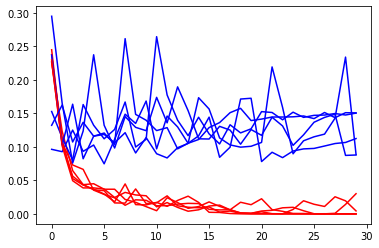

In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

accuracies = list()
precisions = list()
recalls = list()
for _ in range(5): #5 different initializations
  #Initializes model with the hyperparameters
  model_ft = models.resnet50(pretrained=True)
  freeze_resnet(model_ft,33)
  num_ftrs=model_ft.fc.in_features
  model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Linear(1024, 2),
                            ) #A new fully connected layer with output for 2 classes
  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  learner = Learner(model_ft,criterion)

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
  learner.set_optimizer(optimizer,scheduler)


  #trains on the training dataset for 30 epochs and changes to the best model on
  #the validation set (early stopping)
  learner.set_datasets(dates_dataset['train'],dates_dataset['valid'])
  learner.train(30,64,128,batch_cap=64,verbose=False)
  learner.change_to_best_model()

  #evaluates performance on the test set
  preds = learner.predict(dates_dataset['test'],128,2)
  preds[torch.isnan(preds)]=1 #some images may have excessive glitches that result in nan output 
                              #these images can be discarded as non meteors
  preds = preds[:,1].numpy() #Predicted probability of being non meteor
  labels = np.array([dates_dataset['test'][i][1] for i in range(len(dates_dataset['test']))])

  info = accuracy_confidence(preds,labels)
  accuracies.append(info['acc'])
  precisions.append(info['prec'])
  recalls.append(info['rec'])
  print(info)
  print()
 
print(accuracies)
print(precisions)
print(recalls)

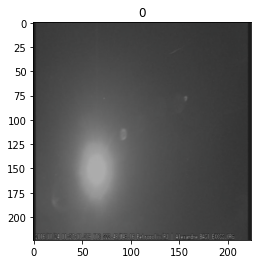

In [ ]:
#Displaying one image from the dataset for debugging purposes

dataloader=torch.utils.data.DataLoader(dates_dataset['train'])
plt.ion() 

# Get a batch of training data
inputs, classes = next(iter(dataloader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes.item()) #Class 0 corresponds to meteor and 1 to non-meteor